# BERTopic

## imports and preliminaries

In [2]:
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download("stopwords")
nltk.download('punkt_tab')

path_to_data = "./text_chunks.tsv"
stopwords = stopwords.words("english")
stopwords.extend(["the", "in", "of"])

#print(stopwords)

# Open training data
training_data = pd.read_csv(path_to_data, sep="\t", header=0)

# Tokenise text and remove stopwords
training_data["TEXT"] = training_data["TEXT"].apply(lambda x: word_tokenize(x))
training_data["TEXT"] = training_data["TEXT"].apply(lambda x: ' '.join([word for word in x if word.lower() not in stopwords]))

#training_data.head(20)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joshua/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/joshua/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## So, is there an ERNIETopic?

In [4]:
# prepare embeddings
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(training_data["TEXT"], show_progress_bar=True)
#reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)


# Train BERTopic
topic_model = BERTopic(verbose=True)
topics, probs = topic_model.fit_transform(training_data["TEXT"])
hierarchical_topics = topic_model.hierarchical_topics(training_data["TEXT"])

# Save model
topic_model.save("./output/bertopic_model", serialization="safetensors", save_ctfidf=True)

Batches:   0%|          | 0/98 [00:00<?, ?it/s]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2024-11-18 15:13:15,397 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/98 [00:00<?, ?it/s]

2024-11-18 15:13:27,227 - BERTopic - Embedding - Completed ✓
2024-11-18 15:13:27,227 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-18 15:13:33,128 - BERTopic - Dimensionality - Completed ✓
2024-11-18 15:13:33,129 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-18 15:13:33,195 - BERTopic - Cluster - Completed ✓
2024-11-18 15:13:33,202 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-18 15:13:33,327 - BERTopic - Representation - Completed ✓
100%|██████████| 48/48 [00:00<00:00, 767.24it/s]


In [5]:
topic_model.get_document_info(training_data["TEXT"])

similar_topics, similarity = topic_model.find_topics("composition", top_n=5)
topic_model.get_topic(similar_topics[0])

[('composition', 0.1936154584100352),
 ('everything', 0.13245050198711977),
 ('naturally', 0.09265550366724383),
 ('different', 0.08684315508981037),
 ('beginning', 0.08601978173520661),
 ('time', 0.07874112211634639),
 ('present', 0.0706503639078337),
 ('thing', 0.06789199325764454),
 ('continuous', 0.061044876771842865),
 ('simply', 0.059288388489029446)]

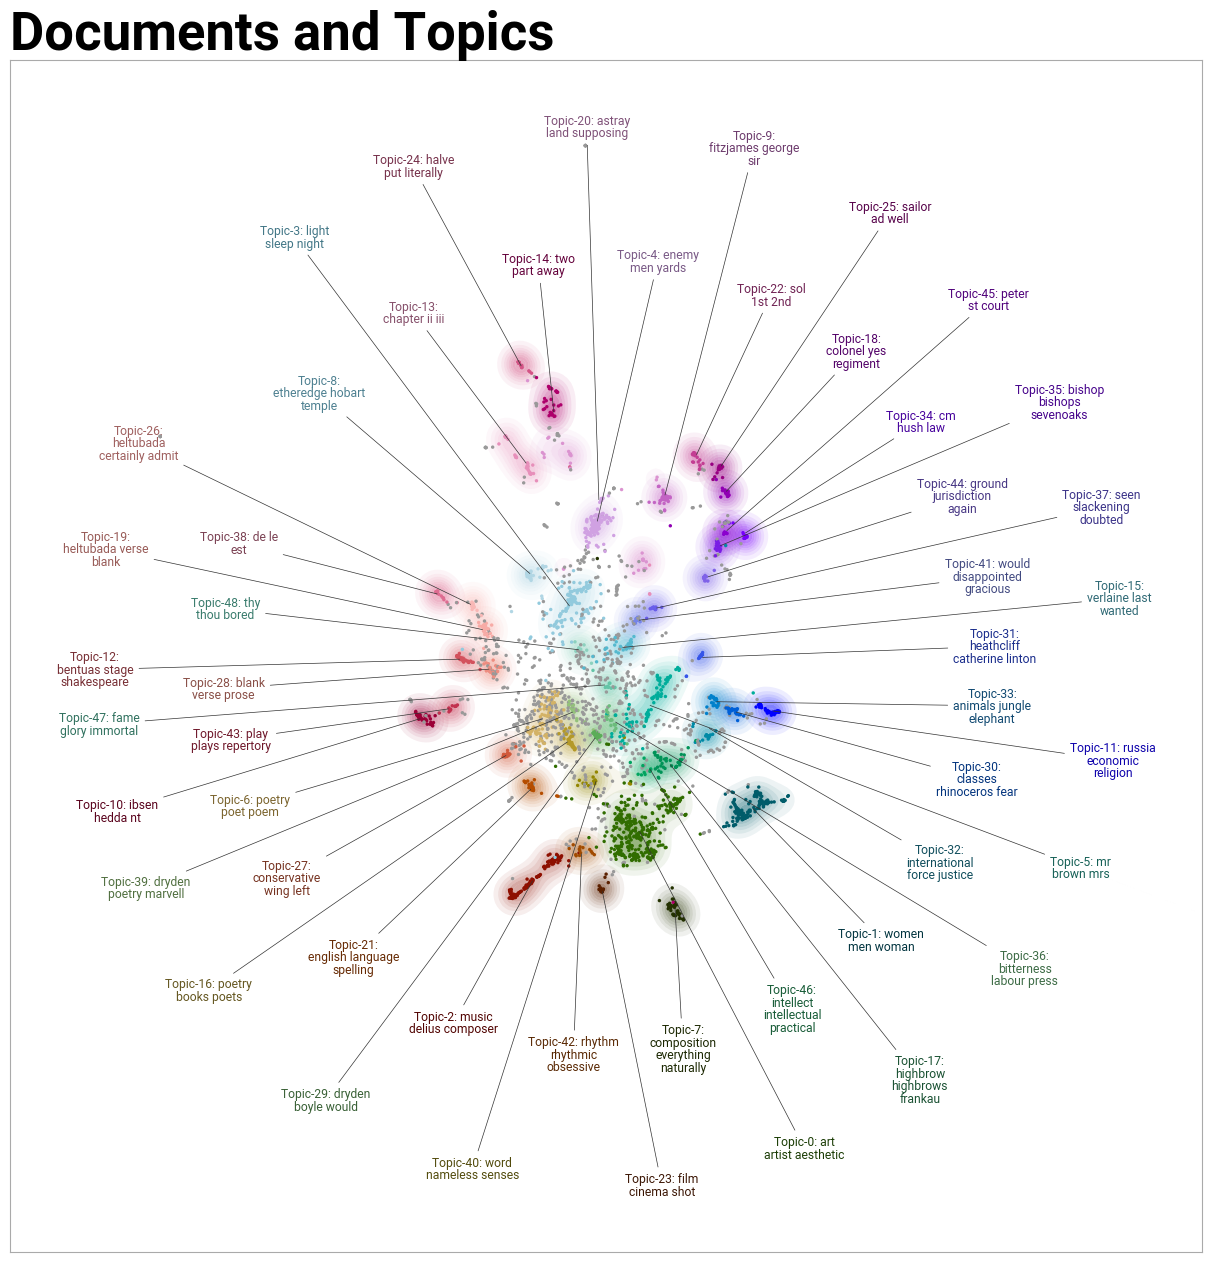

In [15]:
topic_model = topic_model.load("./output/bertopic_model")
docs = training_data["TEXT"]
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)

topic_model.get_topic(0)

datamap = topic_model.visualize_document_datamap(docs, reduced_embeddings=reduced_embeddings)
datamap.savefig("./output/datamap.png")